In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import random
import time

import matplotlib.pyplot as plt

import numpy as np

import os
import sys
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy



In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:

data_dir = '/content/drive/My Drive/raw_data/meme_breeds/'

transformations = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data = datasets.ImageFolder(data_dir, transform = transformations)

In [0]:
n_train_and_valid_examples = int(len(data)*0.85)
n_test_examples = len(data) - n_train_and_valid_examples

train_and_valid_data, test_data = torch.utils.data.random_split(data, 
                                                       [n_train_and_valid_examples, n_test_examples])

n_train_examples = int(len(train_and_valid_data)*0.70)
n_valid_examples = len(train_and_valid_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, 
                                                       [n_train_examples, n_valid_examples])

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4009
Number of validation examples: 1719
Number of testing examples: 1011


In [0]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size = BATCH_SIZE)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

print(model_conv.fc)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Linear(in_features=512, out_features=1000, bias=True)


In [11]:
num_ftrs = model_conv.fc.in_features
num_ftrs

512

In [0]:
# Parameters of newly constructed modules have requires_grad=True by default
model_conv.fc = nn.Linear(num_ftrs, 7)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [0]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model_conv, train_iterator, optimizer_conv, criterion, device)
    valid_loss, valid_acc = evaluate(model_conv, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_conv.state_dict(), 'transfer-model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 25m 16s
	Train Loss: 1.055 | Train Acc: 68.26%
	 Val. Loss: 0.492 |  Val. Acc: 89.00%
Epoch: 02 | Epoch Time: 1m 0s
	Train Loss: 0.436 | Train Acc: 88.90%
	 Val. Loss: 0.336 |  Val. Acc: 90.68%
Epoch: 03 | Epoch Time: 1m 1s
	Train Loss: 0.329 | Train Acc: 91.26%
	 Val. Loss: 0.260 |  Val. Acc: 93.43%
Epoch: 04 | Epoch Time: 1m 0s
	Train Loss: 0.275 | Train Acc: 92.08%
	 Val. Loss: 0.233 |  Val. Acc: 93.61%
Epoch: 05 | Epoch Time: 0m 59s
	Train Loss: 0.242 | Train Acc: 92.99%
	 Val. Loss: 0.220 |  Val. Acc: 93.55%
Epoch: 06 | Epoch Time: 1m 0s
	Train Loss: 0.217 | Train Acc: 94.24%
	 Val. Loss: 0.201 |  Val. Acc: 93.90%
Epoch: 07 | Epoch Time: 0m 59s
	Train Loss: 0.200 | Train Acc: 94.26%
	 Val. Loss: 0.192 |  Val. Acc: 94.71%
Epoch: 08 | Epoch Time: 1m 0s
	Train Loss: 0.190 | Train Acc: 94.69%
	 Val. Loss: 0.182 |  Val. Acc: 94.32%
Epoch: 09 | Epoch Time: 1m 0s
	Train Loss: 0.172 | Train Acc: 95.01%
	 Val. Loss: 0.180 |  Val. Acc: 94.08%
Epoch: 10 | Epoch Time: 

In [18]:

test_loss, test_acc = evaluate(model_conv, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.160 | Test Acc: 95.43%


In [0]:
torch.save(model_conv.state_dict(), '/content/drive/My Drive/doggos/raw_data/meme_breeds/resnet18-model.pt')

In [17]:
from sklearn.metrics import confusion_matrix
model_conv.load_state_dict(torch.load('/content/drive/My Drive/raw_data/meme_breeds/resnet18-model.pt'))

<All keys matched successfully>

[tensor(6), tensor(1), tensor(0), tensor(3), tensor(0), tensor(2), tensor(3), tensor(5), tensor(1), tensor(3), tensor(1), tensor(4), tensor(6), tensor(1), tensor(1), tensor(1), tensor(1), tensor(4), tensor(3), tensor(2), tensor(1), tensor(4), tensor(4), tensor(1), tensor(1), tensor(1), tensor(5), tensor(6), tensor(6), tensor(1), tensor(2), tensor(3), tensor(0), tensor(3), tensor(5), tensor(1), tensor(1), tensor(6), tensor(4), tensor(4), tensor(3), tensor(2), tensor(4), tensor(5), tensor(2), tensor(3), tensor(2), tensor(4), tensor(1), tensor(1), tensor(2), tensor(1), tensor(3), tensor(3), tensor(2), tensor(1), tensor(5), tensor(1), tensor(4), tensor(4), tensor(4), tensor(6), tensor(0), tensor(4), tensor(6), tensor(1), tensor(3), tensor(2), tensor(4), tensor(1), tensor(6), tensor(0), tensor(6), tensor(4), tensor(2), tensor(3), tensor(1), tensor(1), tensor(3), tensor(3), tensor(0), tensor(1), tensor(1), tensor(3), tensor(5), tensor(0), tensor(6), tensor(3), tensor(0), tensor(3), tensor(2)

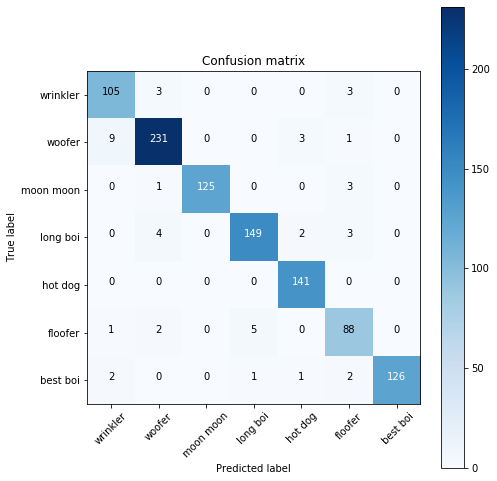

In [40]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def evaluate_pred(model, iterator, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    fx = []
    y_l = []
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            y_l += list(y.cpu())

            fx += list(model(x).argmax(dim=1).cpu())
    return y_l,fx
import itertools
x,y = evaluate_pred(model_conv, test_iterator, device)
print(x,y)
cm = confusion_matrix(x, y)
names = ('wrinkler','woofer','moon moon','long boi',' hot dog', 'floofer',' best boi')
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, names)